<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_07_pytorch_pipeline_01_imbalanced_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Class Imbalance in Machine Learning

**Class imbalance** refers to a situation in a classification problem where the number of instances in different classes is significantly disproportionate. In other words, one class (the majority class) has many more instances than the other class (the minority class).

#### Key Points about Class Imbalance:

1. **Prevalence**:
   - Class imbalance is common in many real-world datasets. Examples include fraud detection (where fraudulent transactions are rare), medical diagnosis (where certain diseases have low prevalence), and spam detection (where spam emails are much fewer than legitimate ones).

2. **Impact on Model Performance**:
   - **Bias Toward Majority Class**: Many machine learning algorithms assume that the classes are balanced. When they are not, the model may become biased toward the majority class, resulting in high accuracy but poor performance on the minority class.
   - **Misleading Metrics**: Accuracy becomes a misleading metric in imbalanced datasets. A model that always predicts the majority class can achieve high accuracy but fails to correctly identify the minority class.
   - **Poor Generalization**: The model might fail to generalize well to unseen data, especially in correctly identifying instances of the minority class.

3. **Performance Metrics for Imbalanced Data**:
   - **Precision**: The proportion of true positives among all predicted positives. Useful when the cost of false positives is high.
   - **Recall (Sensitivity)**: The proportion of true positives among all actual positives. Useful when the cost of false negatives is high.
   - **F1 Score**: The harmonic mean of precision and recall. Provides a balanced measure, especially useful for imbalanced datasets.
   - **ROC-AUC**: Measures the ability of the model to distinguish between classes. The area under the ROC curve (AUC) provides an aggregate measure of performance across all classification thresholds.
   - **Precision-Recall AUC**: Particularly useful for highly imbalanced datasets, focusing on the performance with respect to the minority class.

4. **Techniques to Address Class Imbalance**:
   - **Resampling Techniques**:
     - **Oversampling**: Increasing the number of instances in the minority class. Techniques include Random Oversampling and Synthetic Minority Over-sampling Technique (SMOTE).
     - **Undersampling**: Reducing the number of instances in the majority class. Techniques include Random Undersampling and NearMiss.
   - **Algorithmic Approaches**:
     - **Cost-sensitive Learning**: Assigning different misclassification costs to classes, penalizing the misclassification of the minority class more heavily.
     - **Anomaly Detection Models**: Treating the minority class as anomalies and using specialized models designed for anomaly detection.
   - **Ensemble Methods**:
     - **Balanced Random Forest**: Combining multiple decision trees with resampling to create balanced datasets for each tree.
     - **EasyEnsemble and BalanceCascade**: Combining boosting with undersampling techniques.

5. **Threshold Adjustment**:
   - Adjusting the decision threshold of the classifier to better capture the minority class. For example, lowering the threshold can increase the recall for the minority class at the expense of precision.



#### Visualize Class Imbalance





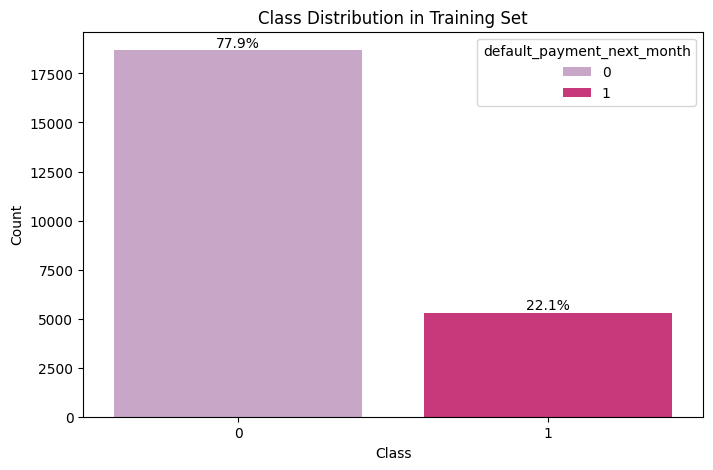

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from model_pipeline import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data

# Define dataset-specific parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
data = load_data_from_url(url)
data = clean_column_names(data)
data = remove_id_column(data)
data = convert_categorical(data, categorical_columns=categorical_columns)
X_train, X_test, y_train, y_test = split_data(data, target=target)

# Plot class balance in the training set with ratio annotations
def plot_class_distribution(y_train):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='PuRd')
    plt.title('Class Distribution in Training Set')
    plt.xlabel('Class')
    plt.ylabel('Count')

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

plot_class_distribution(y_train)

In the context of fraud detection, **recall (sensitivity)** is generally considered more important than precision. Here’s why:

### Importance of Recall in Fraud Detection

1. **High Cost of Missing Fraudulent Transactions**:
   - In fraud detection, the primary goal is to identify as many fraudulent transactions as possible. Missing a fraudulent transaction (false negative) can lead to significant financial losses and potential reputational damage. Therefore, having a high recall ensures that most fraudulent transactions are detected.

2. **Accepting Some False Positives**:
   - While false positives (legitimate transactions flagged as fraudulent) can be inconvenient and may require additional verification steps, the consequences are typically less severe than missing a fraudulent transaction. Companies can manually review flagged transactions to confirm their legitimacy, which is a manageable process.

3. **Safety Net**:
   - Ensuring that most fraud cases are caught, even at the expense of some false alarms, provides a safety net that is crucial for protecting financial assets and maintaining customer trust.

### Balancing Precision and Recall

However, it’s important to find a balance that suits the specific context and resources available. Excessive false positives can lead to customer dissatisfaction and increased operational costs due to manual reviews. Therefore, while recall is prioritized, precision should not be completely disregarded.

### Practical Approach in Fraud Detection

1. **Adjusting the Threshold**:
   - As mentioned earlier, adjusting the decision threshold can help balance recall and precision. Lowering the threshold increases recall but may reduce precision.

2. **Using Evaluation Metrics**:
   - **F1 Score**: The F1 score, which is the harmonic mean of precision and recall, can be a useful metric to find a balance. However, if recall is the priority, you might focus more on maximizing recall even if the F1 score is slightly lower.

3. **Implementing Resampling Techniques**:
   - Techniques like SMOTE or balanced random forests can help improve model performance on the minority class.

4. **Post-Processing**:
   - Implementing rules or secondary models to review flagged transactions can help manage false positives. For example, flagging transactions for manual review if they fall into a certain range of probabilities.




#### Refactor Load and Process Steps

In [ ]:
# Function to be added to model_pipeline.py
script_content = """
import pandas as pd
import torch
from model_pipeline import (
    load_data_from_url,
    clean_column_names,
    remove_id_column,
    convert_categorical,
    split_data,
    define_preprocessor,
    preprocess_data
)

def load_and_preprocess_data(url, categorical_columns, target):
    \"""
    Load and preprocess data from the given URL.

    Parameters:
    url (str): URL of the dataset.
    categorical_columns (list): List of categorical column names.
    target (str): Target column name.

    Returns:
    tuple: Processed training and testing data along with PyTorch tensors.
    \"""
    # Load and preprocess data
    data = load_data_from_url(url)
    data = clean_column_names(data)
    data = remove_id_column(data)
    data = convert_categorical(data, categorical_columns=categorical_columns)
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)
    X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

    return X_train, X_test, y_train, y_test, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor
"""

# Append the function to model_pipeline.py
with open("model_pipeline.py", "a") as file:
    file.write(script_content)

print("Function appended successfully to model_pipeline.py")

# reload script to make function available for use
# Reload the module
import importlib
import model_pipeline
importlib.reload(model_pipeline)

### Understanding Class Weights in Machine Learning

**Class weights** are a mechanism used to address class imbalance in datasets during model training. Class imbalance occurs when the number of instances in different classes is significantly disproportionate, which can lead to biased models that perform poorly on the minority class.

### Key Concepts

1. **Class Imbalance**:
   - In a dataset with class imbalance, the model tends to favor the majority class because it appears more frequently in the training data.
   - This can result in high overall accuracy but poor performance on the minority class (e.g., fraud detection where fraudulent transactions are rare).

2. **Class Weights**:
   - Class weights are used to assign a different level of importance (weight) to each class.
   - By assigning a higher weight to the minority class, the model is penalized more for misclassifying instances of the minority class compared to the majority class.
   - This encourages the model to pay more attention to the minority class during training.

### How Class Weights Affect Model Performance

1. **Balanced Performance**:
   - Properly setting class weights can lead to a more balanced model performance, improving metrics like precision, recall, and F1-score for the minority class.
   - Without class weights, the model may achieve high accuracy but have low recall for the minority class.

2. **Impact on Precision and Recall**:
   - Increasing the weight of the minority class generally improves recall (the ability to identify true positive instances of the minority class) at the expense of precision (the proportion of true positive predictions among all positive predictions).
   - The goal is to find a balance where the model accurately identifies minority class instances while minimizing false positives.

3. **Cost-Sensitive Learning**:
   - Class weights are a form of cost-sensitive learning, where different misclassification costs are applied to different classes.
   - This approach is particularly useful in applications where the cost of false negatives is high, such as medical diagnosis or fraud detection.



#### Optimal Class Weight for Recall

In [20]:
import numpy as np
from sklearn.metrics import recall_score
from model_pipeline import SklearnSimpleNN, train_model, evaluate_model, load_and_preprocess_data

# Define dataset-specific parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
X_train, X_test, y_train, y_test, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = load_and_preprocess_data(url, categorical_columns, target)

# Function to evaluate the model with different class weights
def evaluate_class_weights(class_weights):
    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=class_weights[1])
    nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
    y_pred = nn_estimator.predict(X_test_tensor.numpy())
    recall = recall_score(y_test_tensor.numpy(), y_pred)
    return recall

# Generate a range of class weights to test
class_weight_range = np.linspace(0.5, 5.0, 10)
best_recall = 0
best_weights = None

for weight in class_weight_range:
    class_weights = [1.0, weight]
    recall = evaluate_class_weights(class_weights)
    print(f"Class weights: {class_weights}, Recall: {recall}")
    if recall > best_recall:
        best_recall = recall
        best_weights = class_weights

print(f"Best class weights: {best_weights}, Best Recall: {best_recall}")

# Train and evaluate the model with the best class weights
nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=best_weights[1])
nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
evaluate_model(nn_estimator, X_test_tensor, y_test_tensor)


Class weights: [1.0, 0.5], Recall: 0.2192916352675207
Class weights: [1.0, 1.0], Recall: 0.39261492087415223
Class weights: [1.0, 1.5], Recall: 0.4348153730218538
Class weights: [1.0, 2.0], Recall: 0.5048982667671439
Class weights: [1.0, 2.5], Recall: 0.5275056518462697
Class weights: [1.0, 3.0], Recall: 0.5636774679728711
Class weights: [1.0, 3.5], Recall: 0.5885455915599096
Class weights: [1.0, 4.0], Recall: 0.7053504144687265
Class weights: [1.0, 4.5], Recall: 0.7106254709871892
Class weights: [1.0, 5.0], Recall: 0.718914845516202
Best class weights: [1.0, 5.0], Best Recall: 0.718914845516202
              precision    recall  f1-score   support

         0.0       0.89      0.70      0.78      4673
         1.0       0.39      0.68      0.50      1327

    accuracy                           0.70      6000
   macro avg       0.64      0.69      0.64      6000
weighted avg       0.78      0.70      0.72      6000



### Understanding Class Weights in Machine Learning

**Class weights** are a mechanism used to handle class imbalance in datasets during the training of machine learning models. Class imbalance occurs when one class is significantly underrepresented compared to another, leading to biased models that perform poorly on the minority class.

### Key Concepts

1. **Class Imbalance**:
   - In datasets with class imbalance, models tend to favor the majority class because it has more instances.
   - This can result in high overall accuracy but poor performance on the minority class, which is often the class of interest.

2. **Class Weights**:
   - Class weights adjust the importance of each class during model training.
   - By assigning higher weights to the minority class, the model is penalized more for misclassifying instances of that class.
   - This encourages the model to pay more attention to the minority class and improves its performance on that class.

### How Class Weights Affect Model Performance

1. **Balanced Performance**:
   - Properly setting class weights leads to a more balanced model performance, improving metrics such as recall for the minority class.
   - Without class weights, the model may achieve high accuracy but low recall for the minority class.

2. **Impact on Precision and Recall**:
   - Increasing the weight of the minority class generally improves recall (the ability to identify true positive instances of the minority class) at the expense of precision (the proportion of true positive predictions among all positive predictions).
   - The goal is to find a balance where the model accurately identifies minority class instances while minimizing false positives.

### Best Class Weights Example

Based on your iteration results, the best class weights were `[1.0, 5.0]` with a recall of `0.718914845516202`.

1. **Class 0 Weight (1.0)**:
   - The weight for the majority class (class 0) is set to `1.0`, meaning its importance is unchanged.

2. **Class 1 Weight (5.0)**:
   - The weight for the minority class (class 1) is set to `5.0`, meaning the importance of the minority class is increased fivefold.
   - This increased weight means that misclassifications of the minority class are penalized five times more than those of the majority class.

### Impact of Best Weights

- **Improved Recall**:
  - By setting the weight of the minority class to `5.0`, the model is more sensitive to the minority class. This resulted in a recall of `0.718914845516202`, meaning that approximately 71.9% of the true positive instances of the minority class were correctly identified.
- **Balancing Precision**:
  - While increasing the recall, it is important to monitor precision to ensure that the number of false positives does not become excessively high. However, in scenarios like fraud detection or identifying loan defaults, recall is often prioritized to minimize the risk of missing true positive cases.

### Practical Implementation

- **Class weights** help to address class imbalance by assigning higher importance to the minority class.
- The best class weights `[1.0, 5.0]` increased the model's recall to `0.718914845516202`, demonstrating an improved ability to correctly identify instances of the minority class.
- Properly setting class weights ensures that the model performs better on the minority class, which is crucial in applications where missing true positive cases is costly.

### Understanding Threshold in Machine Learning

**Threshold** is a value used to convert a model’s continuous output (often a probability) into a binary classification. In binary classification problems, models typically output a probability score between 0 and 1 that indicates the likelihood of an instance belonging to the positive class. The threshold determines the cutoff point at which this probability is translated into a binary decision.

### Key Points about Threshold

1. **Definition**:
   - The threshold is the value above which a model classifies an instance as the positive class. For example, if the threshold is set to 0.5, any instance with a predicted probability above 0.5 will be classified as positive, while those below 0.5 will be classified as negative.

2. **Role in Classification**:
   - The threshold plays a crucial role in balancing the trade-offs between precision, recall, and overall accuracy. Adjusting the threshold can significantly impact the model’s performance metrics.

### Impact of Threshold on Model Performance

1. **Precision and Recall**:
   - **Precision**: The proportion of true positive predictions among all positive predictions. Increasing the threshold usually increases precision but may reduce recall.
   - **Recall (Sensitivity)**: The proportion of true positives among all actual positives. Lowering the threshold usually increases recall but may reduce precision.

2. **False Positives and False Negatives**:
   - **False Positives**: Instances incorrectly classified as positive. Raising the threshold can reduce false positives but may increase false negatives.
   - **False Negatives**: Instances incorrectly classified as negative. Lowering the threshold can reduce false negatives but may increase false positives.

3. **Accuracy**:
   - Overall accuracy might not be the best metric in imbalanced datasets. Adjusting the threshold helps in improving other important metrics like precision, recall, and F1-score, which provide a better understanding of the model’s performance on minority classes.

### Choosing the Optimal Threshold

1. **ROC Curve and AUC**:
   - The ROC (Receiver Operating Characteristic) curve plots the true positive rate against the false positive rate at various threshold settings. The area under the ROC curve (AUC) provides an aggregate measure of performance across all thresholds.
   - By analyzing the ROC curve, you can choose a threshold that balances true positives and false positives according to your specific needs.

2. **Precision-Recall Curve**:
   - The precision-recall curve is particularly useful for imbalanced datasets. It plots precision against recall for different thresholds, helping you find a threshold that achieves the desired balance between these two metrics.




#### Optimal Threshold Identification

1. **Primary Focus on Recall**:
   - The function prints recall first for each threshold, highlighting its importance.
   - It tracks the best recall score and the corresponding threshold, ensuring that the threshold maximizing recall is identified and emphasized.

2. **Best Recall Tracking**:
   - Introduces variables `best_recall` and `best_threshold` to store the highest recall score and the threshold at which it occurs.
   - After evaluating all thresholds, it prints the best recall and its associated threshold.



Threshold: 0.10, Recall: 0.6518, Precision: 0.4289, F1-score: 0.5173
Threshold: 0.20, Recall: 0.6194, Precision: 0.4482, F1-score: 0.5201
Threshold: 0.30, Recall: 0.5976, Precision: 0.4684, F1-score: 0.5252
Threshold: 0.40, Recall: 0.5863, Precision: 0.4905, F1-score: 0.5342
Threshold: 0.50, Recall: 0.5576, Precision: 0.5003, F1-score: 0.5274
Threshold: 0.60, Recall: 0.5396, Precision: 0.5207, F1-score: 0.5300
Threshold: 0.70, Recall: 0.5200, Precision: 0.5386, F1-score: 0.5291
Threshold: 0.80, Recall: 0.5034, Precision: 0.5609, F1-score: 0.5306
Best Threshold for Recall: 0.10, Best Recall: 0.6518


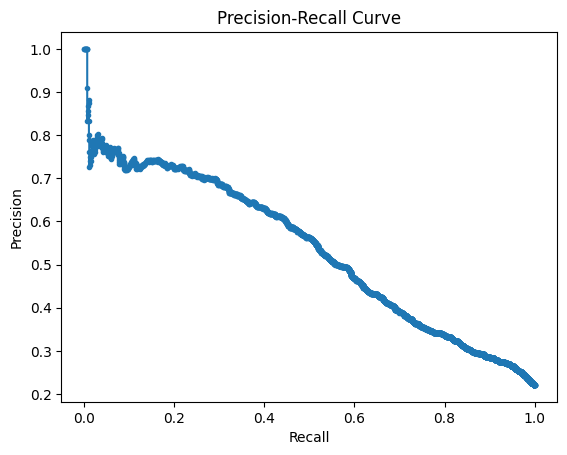

In [22]:
import numpy as np
import torch
from sklearn.metrics import classification_report, precision_recall_curve, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from model_pipeline import load_and_preprocess_data, SklearnSimpleNN, train_model

# Define dataset-specific parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
X_train, X_test, y_train, y_test, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = load_and_preprocess_data(url, categorical_columns, target)

# Best class weights obtained from previous evaluation
best_weights = [1.0, 5.0]

# Train the model with the best class weights
nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=best_weights[1])
nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)

# Predict probabilities on the test set
y_prob = nn_estimator.model(X_test_tensor).detach().numpy().squeeze()

# Function to evaluate model performance at different thresholds, prioritizing recall
def evaluate_thresholds(y_prob, y_test_tensor, thresholds):
    results = []
    best_recall = 0
    best_threshold = 0
    for threshold in thresholds:
        y_pred = (y_prob > threshold).astype(int)
        recall = recall_score(y_test_tensor.numpy(), y_pred)
        precision = precision_score(y_test_tensor.numpy(), y_pred)
        f1 = f1_score(y_test_tensor.numpy(), y_pred)
        results.append((threshold, f1, precision, recall))
        print(f"Threshold: {threshold:.2f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1-score: {f1:.4f}")
        if recall > best_recall:
            best_recall = recall
            best_threshold = threshold
    print(f"Best Threshold for Recall: {best_threshold:.2f}, Best Recall: {best_recall:.4f}")
    return results

# Define a range of thresholds to evaluate
thresholds = np.arange(0.1, 0.9, 0.1)

# Evaluate and print the results for each threshold
results = evaluate_thresholds(y_prob, y_test_tensor, thresholds)

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test_tensor.numpy(), y_prob)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

Interpreting the best recall value involves understanding the trade-offs and implications of choosing a specific threshold in the context of your application. Let's break down the interpretation of the best recall value and threshold:

#### Interpretation of Best Recall:

**Best Threshold for Recall: 0.10, Best Recall: 0.6518**

1. **Threshold of 0.10**:
   - This means that any predicted probability greater than 0.10 will be classified as the positive class (e.g., predicting a default on a loan).
   - A low threshold like 0.10 indicates that the model is being very lenient in classifying instances as positive, which generally increases recall.

2. **Recall of 0.6518**:
   - Recall (Sensitivity) of 0.6518 means that the model correctly identifies approximately 65.18% of all actual positive instances (e.g., actual loan defaults).
   - This is the proportion of true positives among all actual positives. For instance, if there are 100 actual positive cases, the model correctly identifies about 65 of them.

### Trade-offs and Implications:

1. **High Recall, Lower Precision**:
   - By setting a low threshold, the model is more likely to classify instances as positive, increasing the chances of catching true positives (high recall).
   - However, this usually comes at the cost of precision. More instances classified as positive may include many false positives, reducing precision (the proportion of true positives among all predicted positives).

2. **Application Context**:
   - In loan default prediction or fraud detection, high recall is often prioritized because missing true positives can be costly.
   - For example, identifying as many potential defaults as possible can help a financial institution mitigate risk, even if it means some non-defaults are flagged (false positives).

3. **Balancing Precision and Recall**:
   - While a high recall ensures that most positive cases are identified, it's important to monitor precision to avoid too many false positives.
   - The precision-recall trade-off can be managed based on the specific needs and costs associated with false positives and false negatives in your application.

### Conclusion:

If the context is loan default prediction:

- **High Recall**: Ensures that the model identifies most of the borrowers who will default. This is critical for taking preemptive measures to mitigate financial risk.
- **Low Threshold**: Setting the threshold at 0.10 means the model is very cautious, preferring to err on the side of caution by flagging more loans as potential defaults.
- **Actionable Insights**: Financial institutions can use this model to identify high-risk loans, although they may need additional verification steps to confirm actual defaults due to the potential for false positives.


### Understanding SMOTE, Over-Sampling, and Under-Sampling

**1. SMOTE (Synthetic Minority Over-sampling Technique)**:
   - **Purpose**: To address class imbalance by generating synthetic samples for the minority class.
   - **How It Works**: SMOTE creates new instances by interpolating between existing minority class samples. It selects two or more similar instances and generates a new instance that lies somewhere between them.
   - **Benefits**: Increases the number of minority class samples without simply duplicating them, which helps in improving model performance on imbalanced datasets.
   - **Use Case**: Effective when you have a small number of minority class instances and want to create a more balanced dataset.

**2. Over-Sampling**:
   - **Purpose**: To balance class distribution by increasing the number of minority class instances.
   - **How It Works**: Over-sampling methods can either duplicate existing minority class instances (random over-sampling) or generate new synthetic instances (like SMOTE).
   - **Benefits**: Ensures the model has enough examples of the minority class, which can improve the learning process and model performance on the minority class.
   - **Drawbacks**: Random over-sampling can lead to overfitting since it duplicates existing instances.

**3. Under-Sampling**:
   - **Purpose**: To balance class distribution by reducing the number of majority class instances.
   - **How It Works**: Under-sampling methods randomly remove instances from the majority class to balance the dataset.
   - **Benefits**: Reduces the size of the dataset, which can speed up training and reduce computational costs.
   - **Drawbacks**: Can lead to the loss of important information and potentially underfitting, as valuable majority class instances are discarded.

### Key Points

- **Class Imbalance**: Occurs when the number of instances in one class significantly outweighs the number of instances in another class, leading to biased models.
- **Balanced Dataset**: Achieved through techniques like SMOTE, over-sampling, and under-sampling, which help the model to learn equally well for both classes.
- **Performance Metrics**: Techniques like SMOTE and over/under-sampling improve performance metrics such as recall, precision, and F1-score, particularly for the minority class.

### When to Use

- **SMOTE**: Use when you need to generate synthetic samples for the minority class and avoid overfitting caused by simple duplication.
- **Over-Sampling**: Use when you have a severely imbalanced dataset and want to ensure that the model has enough minority class examples.
- **Under-Sampling**: Use when you want to quickly balance the dataset and are willing to reduce the majority class instances, keeping in mind the risk of losing important information.

By applying these techniques, you can improve the performance of machine learning models on imbalanced datasets, ensuring better generalization and more reliable predictions for minority class instances.

#### Code Adjustments

1. **Ensure Consistent Preprocessing**:
   - Applied the same preprocessing steps to both training and test sets using `ColumnTransformer` and `Pipeline`.

2. **Convert DataFrames to NumPy Arrays**:
   - After applying SMOTE, converted the resulting DataFrames to NumPy arrays before converting them to PyTorch tensors.

3. **Refactor `load_and_preprocess_data` Function**:
   - Ensured the function correctly returns DataFrames and tensors.

4. **Updated Code for Tensor Conversion**:
   - Explicitly converted preprocessed test data to NumPy arrays using `.toarray()` before converting to PyTorch tensors.

These changes ensure that the data is correctly preprocessed, converted, and consistent between the training and test sets when using SMOTE.

### Create imbalanced_data_utils.py

In [50]:
# Define the content for imbalanced_data_utils.py
imbalanced_utils_content = """
import numpy as np
import torch
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
from model_pipeline import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data, define_preprocessor, preprocess_data, calculate_class_weights, SklearnSimpleNN, train_model, evaluate_model
import argparse


# Function to apply SMOTE and convert to tensors
def apply_smote_and_convert_to_tensors(X_train_processed, y_train):
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)

    # Convert resampled data to tensors
    X_train_tensor_res = torch.tensor(X_train_res, dtype=torch.float32)
    y_train_tensor_res = torch.tensor(y_train_res, dtype=torch.float32).unsqueeze(1)

    return X_train_tensor_res, y_train_tensor_res, y_train_res

# Function to evaluate model performance at different thresholds, prioritizing recall
def evaluate_thresholds(y_prob, y_test_tensor, thresholds):
    results = []
    best_recall = 0
    best_threshold = 0
    for threshold in thresholds:
        y_pred = (y_prob > threshold).astype(int)
        recall = recall_score(y_test_tensor.numpy(), y_pred)
        precision = precision_score(y_test_tensor.numpy(), y_pred)
        f1 = f1_score(y_test_tensor.numpy(), y_pred)
        results.append((threshold, f1, precision, recall))
        print(f"Threshold: {threshold:.2f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1-score: {f1:.4f}")
        if recall > best_recall:
            best_recall = recall
            best_threshold = threshold
    print(f"Best Threshold for Recall: {best_threshold:.2f}, Best Recall: {best_recall:.4f}")
    return results

# Function to plot Precision-Recall curve
def plot_precision_recall_curve(y_test_tensor, y_prob):
    precision, recall, _ = precision_recall_curve(y_test_tensor.numpy(), y_prob)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

# Function to run the full pipeline with SMOTE
def run_full_pipeline_with_smote(url, categorical_columns, target):
    # Load and preprocess data
    data = load_data_from_url(url)
    data = clean_column_names(data)
    data = remove_id_column(data)
    data = convert_categorical(data, categorical_columns=categorical_columns)
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)
    X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    # Apply SMOTE and convert to tensors
    X_train_tensor_res, y_train_tensor_res, y_train_res = apply_smote_and_convert_to_tensors(X_train_processed, y_train)

    # Calculate class weights
    class_weights = calculate_class_weights(y_train_res)

    # Train and evaluate the model
    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor_res.shape[1], pos_weight=class_weights[1])
    nn_estimator = train_model(nn_estimator, X_train_tensor_res, y_train_tensor_res)
    X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
    evaluate_model(nn_estimator, X_test_tensor, y_test_tensor)

    # Predict probabilities on the test set
    y_prob = nn_estimator.model(X_test_tensor).detach().numpy().squeeze()

    return y_prob, y_test_tensor

# Define the main function to evaluate thresholds
def evaluate_model_with_smote(url, categorical_columns, target):
    y_prob, y_test_tensor = run_full_pipeline_with_smote(url, categorical_columns, target)

    # Define a range of thresholds to evaluate
    thresholds = np.arange(0.1, 0.9, 0.1)

    # Evaluate and print the results for each threshold
    results = evaluate_thresholds(y_prob, y_test_tensor, thresholds)

    # Plot Precision-Recall curve
    plot_precision_recall_curve(y_test_tensor, y_prob)

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Evaluate model with SMOTE")
    parser.add_argument("url", type=str, help="URL of the dataset")
    parser.add_argument("categorical_columns", type=str, nargs="+", help="List of categorical columns")
    parser.add_argument("target", type=str, help="Target column")

    args = parser.parse_args()

    evaluate_model_with_smote(args.url, args.categorical_columns, args.target)

if __name__ == "__main__":
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
    categorical_columns = ['sex', 'education', 'marriage']
    target = 'default_payment_next_month'
    evaluate_model_with_smote(url, categorical_columns, target)

"""

# Write the content to imbalanced_data_utils.py
with open("imbalanced_data_utils.py", "w") as file:
    file.write(imbalanced_utils_content)

print("imbalanced_data_utils.py created successfully")


imbalanced_data_utils.py created successfully


              precision    recall  f1-score   support

         0.0       0.87      0.80      0.83      4673
         1.0       0.46      0.60      0.52      1327

    accuracy                           0.75      6000
   macro avg       0.67      0.70      0.68      6000
weighted avg       0.78      0.75      0.76      6000

Threshold: 0.10, Recall: 0.5644, Precision: 0.4783, F1-score: 0.5178
Threshold: 0.20, Recall: 0.5433, Precision: 0.4979, F1-score: 0.5196
Threshold: 0.30, Recall: 0.5260, Precision: 0.5147, F1-score: 0.5203
Threshold: 0.40, Recall: 0.5064, Precision: 0.5304, F1-score: 0.5181
Threshold: 0.50, Recall: 0.4913, Precision: 0.5420, F1-score: 0.5154
Threshold: 0.60, Recall: 0.4695, Precision: 0.5553, F1-score: 0.5088
Threshold: 0.70, Recall: 0.4537, Precision: 0.5772, F1-score: 0.5080
Threshold: 0.80, Recall: 0.4310, Precision: 0.5927, F1-score: 0.4991
Best Threshold for Recall: 0.10, Best Recall: 0.5644


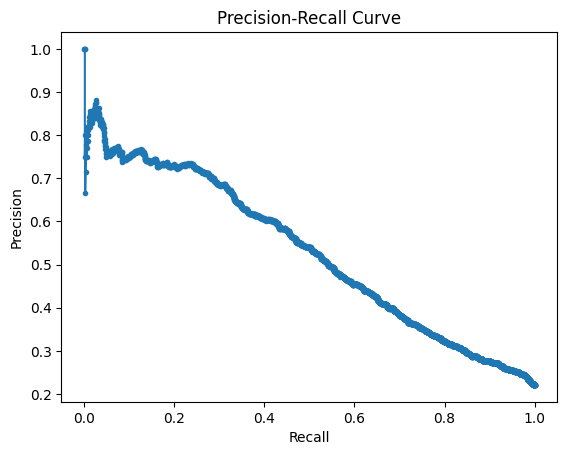

In [51]:
import numpy as np
import torch
from imbalanced_data_utils import evaluate_model_with_smote

# Assign variables
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Run the function
evaluate_model_with_smote(url, categorical_columns, target)


The order of operations in your workflow is crucial and can significantly affect the outcomes. Let's break down the proper sequence of steps for handling imbalanced data and finding optimal thresholds and weights:

1. **Apply SMOTE**:
   - **Purpose**: To balance the dataset by generating synthetic samples for the minority class.
   - **When to Apply**: Before determining class weights and before training the model.

2. **Determine Class Weights**:
   - **Purpose**: To handle class imbalance by assigning higher weights to the minority class.
   - **When to Apply**: After applying SMOTE but before training the model.

3. **Train the Model**:
   - **Purpose**: To learn from the balanced dataset.
   - **When to Apply**: After applying SMOTE and determining class weights.

4. **Determine Optimal Threshold**:
   - **Purpose**: To find the best decision threshold for the model to optimize the desired metric (e.g., recall).
   - **When to Apply**: After training the model.

### Correct Sequence of Operations

1. **Apply SMOTE** to the training data.
2. **Determine Class Weights** based on the resampled data.
3. **Train the Model** using the resampled data and class weights.
4. **Determine Optimal Threshold** for the model predictions.

### Updated Code Sequence

#### `imbalanced_data_utils.py`

Ensure the functions follow the correct sequence:

```python
import numpy as np
import torch
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
from model_pipeline import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data, define_preprocessor, preprocess_data, calculate_class_weights, SklearnSimpleNN, train_model, evaluate_model

# Function to apply SMOTE and convert to tensors
def apply_smote_and_convert_to_tensors(X_train_processed, y_train):
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)
    
    # Convert resampled data to tensors
    X_train_tensor_res = torch.tensor(X_train_res, dtype=torch.float32)
    y_train_tensor_res = torch.tensor(y_train_res, dtype=torch.float32).unsqueeze(1)
    
    return X_train_tensor_res, y_train_tensor_res, y_train_res

# Function to evaluate model performance at different thresholds, prioritizing recall
def evaluate_thresholds(y_prob, y_test_tensor, thresholds):
    results = []
    best_recall = 0
    best_threshold = 0
    for threshold in thresholds:
        y_pred = (y_prob > threshold).astype(int)
        recall = recall_score(y_test_tensor.numpy(), y_pred)
        precision = precision_score(y_test_tensor.numpy(), y_pred)
        f1 = f1_score(y_test_tensor.numpy(), y_pred)
        results.append((threshold, f1, precision, recall))
        print(f"Threshold: {threshold:.2f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1-score: {f1:.4f}")
        if recall > best_recall:
            best_recall = recall
            best_threshold = threshold
    print(f"Best Threshold for Recall: {best_threshold:.2f}, Best Recall: {best_recall:.4f}")
    return results

# Function to plot Precision-Recall curve
def plot_precision_recall_curve(y_test_tensor, y_prob):
    precision, recall, _ = precision_recall_curve(y_test_tensor.numpy(), y_prob)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

# Function to run the full pipeline with SMOTE
def run_full_pipeline_with_smote(url, categorical_columns, target):
    # Load and preprocess data
    data = load_data_from_url(url)
    data = clean_column_names(data)
    data = remove_id_column(data)
    data = convert_categorical(data, categorical_columns=categorical_columns)
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)
    X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)
    
    # Apply SMOTE and convert to tensors
    X_train_tensor_res, y_train_tensor_res, y_train_res = apply_smote_and_convert_to_tensors(X_train_processed, y_train)
    
    # Calculate class weights
    class_weights = calculate_class_weights(y_train_res)
    
    # Train and evaluate the model
    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor_res.shape[1], pos_weight=class_weights[1])
    nn_estimator = train_model(nn_estimator, X_train_tensor_res, y_train_tensor_res)
    X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
    evaluate_model(nn_estimator, X_test_tensor, y_test_tensor)

    # Predict probabilities on the test set
    y_prob = nn_estimator.model(X_test_tensor).detach().numpy().squeeze()

    return y_prob, y_test_tensor

# Define the main function to evaluate thresholds
def evaluate_model_with_smote(url, categorical_columns, target):
    y_prob, y_test_tensor = run_full_pipeline_with_smote(url, categorical_columns, target)

    # Define a range of thresholds to evaluate
    thresholds = np.arange(0.1, 0.9, 0.1)

    # Evaluate and print the results for each threshold
    results = evaluate_thresholds(y_prob, y_test_tensor, thresholds)

    # Plot Precision-Recall curve
    plot_precision_recall_curve(y_test_tensor, y_prob)

if __name__ == "__main__":
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
    categorical_columns = ['sex', 'education', 'marriage']
    target = 'default_payment_next_month'
    evaluate_model_with_smote(url, categorical_columns, target)
```

### Main Script

```python
import numpy as np
import torch
from imbalanced_data_utils import evaluate_model_with_smote

# Assign variables
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Run the function
evaluate_model_with_smote(url, categorical_columns, target)
```

### Summary

1. **Apply SMOTE** first to balance the dataset.
2. **Determine Class Weights** after applying SMOTE.
3. **Train the Model** using the balanced data and class weights.
4. **Evaluate the Thresholds** after training the model to find the optimal decision threshold.

Run the updated scripts and check if the recall improves. If there are any issues, provide the error messages, and I can help troubleshoot them.